# Тетрадка содержит код для составления расписания и маршрутов объезда банкоматов

Данные для моделирования 

    - величина % в годовых, которую банк платит за неинкассированную сумму денег в терминале - 2 (т.е. сумма за день = остаток * 2/100/365);
    - стоимость обслуживания одного терминала в случае его инкассирования = 0,01% от суммы инкассации, но не менее 100 рублей (т.е. для суммы 50000 = 100, для суммы 1500000 = 150);
    - максимально допустимая сумма денег в терминале - 1000000;
    - максимально допустимое время, в течение которого терминал можно не обслуживать - 14 дней;
    - стоимость одного броневика на день - 20000;
    - начало и конец рабочего дня броневиков - c 08:00 по 20:00 мск. времени;
    - время простоя броневика на точке (время на инкассирование) - 10 минут


Возьмём терминал 406136: 
На утро 01.09 остаток = 160000.

Если его обслужить 01.09 и забрать 160000, то остаток на вечер будет = 0, платить за фондирование 01.09 не надо. Но будут издержки = 100 руб. за обслуживание.
1.1. На утро 02.09 остаток станет = 90000. Добавятся 90000 из оборотов 01.09. 

Если его не обслужить 01.09, то на вечер 01.09 остаток будет = 160000 и 01.09 у вас возникают издержки, связанные с фондированием = 7.45. Издержек за обслуживание не будет.
2.1. На утро 02.09 остаток станет = 250000 (160000 + 90000 поступлений за 01.09).
	2.1.1. Если 02.09 обслужить терминал, то остаток на вечер = 0. Фондирование = 0. Издержки за обслуживание = 100.
	2.1.2. Если 02.09 не обслуживать терминал, то остаток на вечер = 250000. Фондирование = 13.70. Издержки за обслуживание = 0.


In [1]:
import pandas as pd

import matplotlib.pyplot as plt

from bank_schedule.data import Data
from bank_schedule import scheduler, ortools_tsp
from bank_schedule import output, check_conditions
from bank_schedule.constants import RAW_DATA_FOLDER

In [2]:
loader = Data(RAW_DATA_FOLDER)
distances_df = loader.get_distance_matrix()
geo_df = loader.get_geo_TIDS()
incomes_df = loader.get_money_in()

initial_residuals = scheduler.get_initial_resuduals(loader,
                                                    last_collection_method='constant')

In [3]:
# Оценим теоретически достижимое максимальное число точек,
# которое может обслужить одна машина за день
sort_dist = distances_df.sort_values(by='Total_Time')

# прибавляем ко времени пути время на инкассацию
sort_dist['Total_Time'] += 10

# считаем куммулятивную сумму так, как будто все близкие точки попали в один кластер
# и мы их последовательно инкассируем
sort_dist['cumsum_time'] = sort_dist['Total_Time'].cumsum()

# смотрим, сколько точек мы успели объехать
max_tids = sort_dist[sort_dist['cumsum_time'] < 12 * 60].shape[0]
print('Максимальное теоретически достижимое число точек на 1 машину:', max_tids)

Максимальное теоретически достижимое число точек на 1 машину: 70


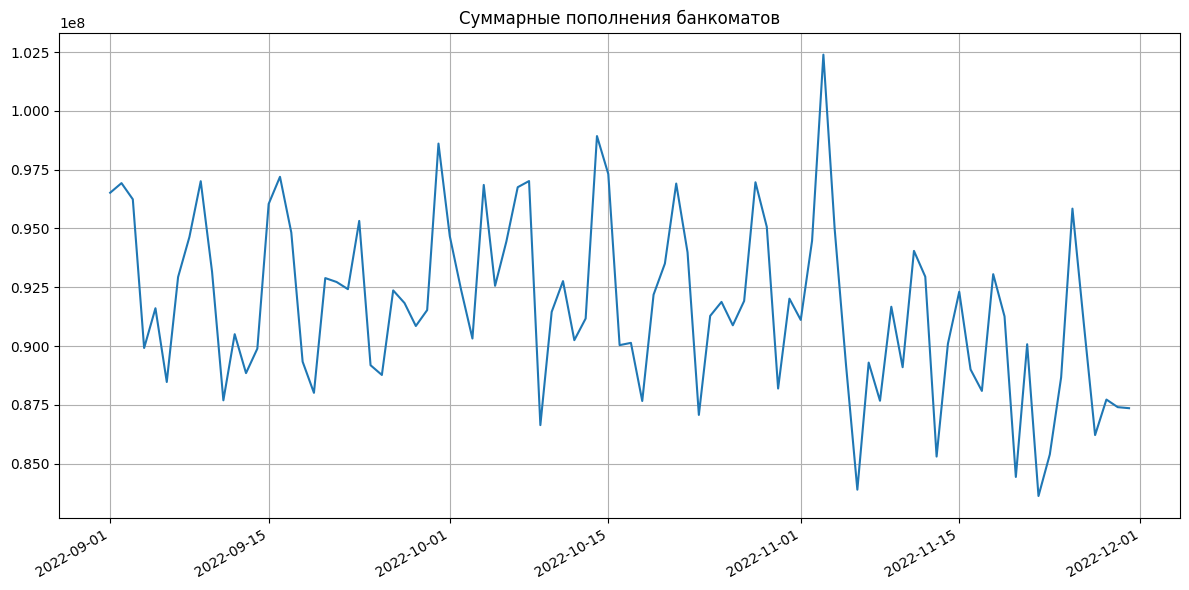

In [4]:
summary_incomes = incomes_df.groupby('date')['money_in'].sum()

fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(summary_incomes)
plt.title('Суммарные пополнения банкоматов')
fig.autofmt_xdate()
plt.tight_layout()
plt.grid()
plt.show()

## Подготовка расписания инкассации по дням

In [6]:
schedule_df = \
    scheduler.prepare_schedule(
        loader, # загрузчик данных
        forecast_horizon=30, # горизонт прогноза при ежедневном обновлении расписания
        deadline_threshold=1, # за сколько дней до "дедлайна" инкассировать банкоматы
        atms_per_day_min=150, # сколько банкоматов минимум надо объехать задень
        neighborhood_radius=15, # в каком радиусе времени пути банкоматы подходят для попутного объезда
        use_greedy_scheduler=False, # использовать жадный настройщик расписания
        use_real_data_for_update=True, # использовать реальные данные для обновления расписания
        last_collection_method='constant', # как проставлять дату последней инкассации в файле остатков
        forecast_model_name='lgbm', # какую модель использовать для прогноза
        end_date='2022-11-30' # какой датой закончить прогноз (дата начала берется из файла остатков)
        )

/Users/affernus/PROJECTS/hacks/bank_schedule/src/bank_schedule/forecast.py:265: UserWarning: Дата 2022-08-31 00:00:00 не найдена в данных, прогнозируем средним по TID
  warn(f'Дата {today_date} не найдена в данных, прогнозируем средним по TID')


In [7]:
display(schedule_df)

,TID,money,date,last_collection_date,overflow_date,days_to_deadline,is_mandatory
0,644823,137000,2022-09-01,2022-08-31,NaT,14,0
1,669434,298000,2022-09-01,2022-08-31,2022-09-19,14,0
2,649162,137000,2022-09-01,2022-08-31,2022-09-18,14,0
3,644742,327000,2022-09-01,2022-08-31,2022-09-22,14,0
4,636008,52000,2022-09-01,2022-08-31,2022-09-27,14,0
...,...,...,...,...,...,...,...
13645,691498,947000,2022-11-30,2022-11-17,2022-11-30,1,1
13646,692611,913000,2022-11-30,2022-11-25,2022-11-30,1,1
13647,693072,273000,2022-11-30,2022-11-16,NaT,1,1
13648,698690,188000,2022-11-30,2022-11-16,NaT,1,1


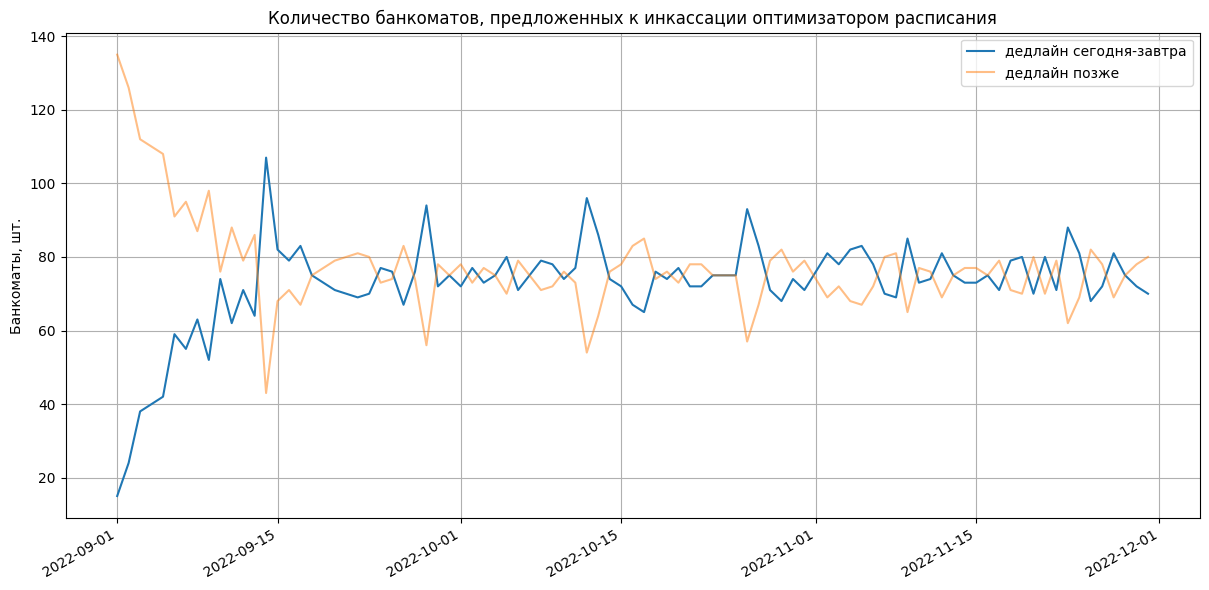

In [8]:
mandatory_atms_ts = schedule_df.groupby('date')['is_mandatory'].sum()
other_atms_series = schedule_df.groupby('date')['is_mandatory'].count() - mandatory_atms_ts

fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(pd.Series(mandatory_atms_ts), label='дедлайн сегодня-завтра')
plt.plot(pd.Series(other_atms_series), label='дедлайн позже', alpha=.5)
plt.title('Количество банкоматов, предложенных к инкассации оптимизатором расписания')
fig.autofmt_xdate()
plt.tight_layout()
plt.legend()
plt.ylabel('Банкоматы, шт.')
plt.grid()
plt.show()

In [9]:
car_routes_dict, cars_routes_times_dict = \
    ortools_tsp.optimize_routes(loader, # загрузчик данных
                                schedule_df, # датафрейм с расписанием инкассации
                                n_iterations=5, # количество итераций построения маршрута. Выбирается лучшее решение из полученных
                                max_route_time=719.5, # максимально допустимое время маршрута в минутах для одного броневика
                                verbose=True) # выводит в консоль информацию о процессе

date: 2022-09-01 00:00:00 | max route time: 712.26 | max route time: 376.2  | number of cars: 4 | ATMs visited: 150
date: 2022-09-02 00:00:00 | max route time: 719.0  | max route time: 458.51 | number of cars: 4 | ATMs visited: 150
date: 2022-09-03 00:00:00 | max route time: 709.27 | max route time: 403.96 | number of cars: 5 | ATMs visited: 150
date: 2022-09-04 00:00:00 | max route time: 718.17 | max route time: 218.99 | number of cars: 5 | ATMs visited: 150
date: 2022-09-05 00:00:00 | max route time: 715.22 | max route time: 206.25 | number of cars: 5 | ATMs visited: 150
date: 2022-09-06 00:00:00 | max route time: 713.92 | max route time: 502.47 | number of cars: 5 | ATMs visited: 150
date: 2022-09-07 00:00:00 | max route time: 718.8  | max route time: 598.36 | number of cars: 5 | ATMs visited: 150
date: 2022-09-08 00:00:00 | max route time: 714.06 | max route time: 654.72 | number of cars: 5 | ATMs visited: 150
date: 2022-09-09 00:00:00 | max route time: 718.76 | max route time: 280

In [19]:
# подготовка файла с результатами оптимизации маршрутов
result_df = ortools_tsp.prepare_tsp_result(car_routes_dict)
display(result_df)

,number,TID,date,auto
0,0,646576,2022-09-01,1
1,1,693201,2022-09-01,1
2,2,619188,2022-09-01,1
3,3,634903,2022-09-01,1
4,4,645058,2022-09-01,1
...,...,...,...,...
13645,27,635286,2022-11-30,5
13646,28,606518,2022-11-30,5
13647,29,619657,2022-11-30,5
13648,30,607096,2022-11-30,5


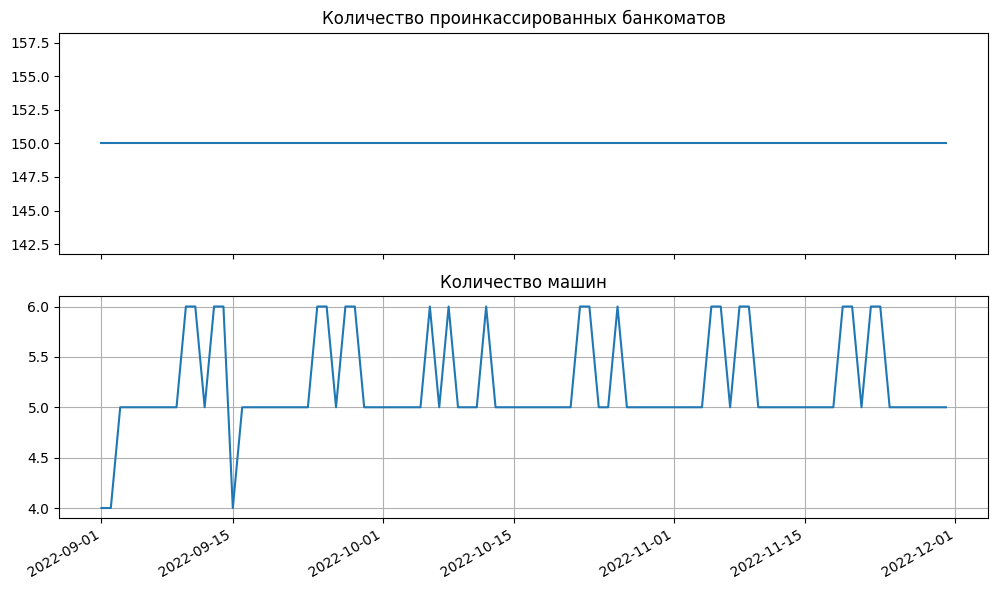

In [20]:
fig, axs = plt.subplots(ncols=1, nrows=2, sharex=True, figsize=(10, 6))
ax1, ax2 = axs

ax1.plot(result_df.groupby('date')['TID'].agg(lambda x: len(set(x))))
ax1.set_title('Количество проинкассированных банкоматов')

ax2.plot(result_df.groupby('date')['auto'].agg(lambda x: len(set(x))))
ax2.set_title('Количество машин')

fig.autofmt_xdate()
plt.tight_layout()
plt.grid()
plt.show()

## Проверка ограничений и подготовка отчета

In [21]:
# проверка ограничений на время (с 8 утра до 8 вечера) + составления маршрутов для отчета
df_routes = output.find_routes_check_2(result_df, loader)
df_opt_result = df_routes[['TID', 'date', 'auto']]

check_conditions.condition_max_days_inc(df_opt_result, loader)
check_conditions.check_over_balance(df_opt_result, loader)

df_money_sum = output.find_ATM_balance_evening(df_opt_result, loader) 
df_money_sum_morning = output.find_ATM_balance_morning(df_opt_result, loader) 
all_cost_by_days, all_cost_inc, df_fond = output.find_all_cost(df_money_sum,
                                                               df_opt_result,
                                                               loader) 

# создание отчета
output.postprocessing_and_make_excel('schedule_optimization_result.xlsx',
                                     df_money_sum_morning,
                                     df_fond,
                                     all_cost_inc,
                                     all_cost_by_days, df_routes)

find routes for auto=1
find routes for auto=2
find routes for auto=3
find routes for auto=4
find routes for auto=5
find routes for auto=6


100%|██████████| 91/91 [00:11<00:00,  7.99it/s]
